<a href="https://colab.research.google.com/github/3minuterecord/myJup/blob/master/MTG_GPT_2_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Fine Tune GPT-2 for Safety Incident Narrative Generation.

Use [PyTorch](https://pytorch.org/) and Transformers from [Hugging Face](https://huggingface.co/) to fine tune a [GPT-2 Model](https://openai.com/blog/gpt-2-1-5b-release/) to fabricate fake 'topic specific' incident descriptions. The intention is to use these fabricated incident descriptions to augment training data for supervised topic classification models.

Code chunk references:
- [Rey Farhan](http://reyfarhan.com/posts/easy-gpt2-finetuning-huggingface/)
- [Chris McCormick's](https://mccormickml.com/2019/07/22/BERT-fine-tuning/) BERT fine-tuning tutorial
- [Ian Porter's](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html) GPT2 tutorial 
- [Hugging Face](https://huggingface.co/transformers/v2.0.0/examples.html#language-model-fine-tuning) Language model fine-tuning script.

**NOTE**
Check this repo for possibly some good examples on transformer based augmentation

https://blog.paperspace.com/data-augmentation-for-nlp/

In [1]:
# Mount Google drive to access datasets.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab_Notebooks/safety_report_tc

/content/drive/MyDrive/Colab_Notebooks/safety_report_tc


### Load Data & Support Packages

- Install the Huggingface transformers library. 
- Installing transformers will also install tokenizers (a dependency and another useful set of tools for this task).

In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 32.0 MB/s 
     |████████████████████████████████| 7.6 MB 94.1 MB/s 
     |████████████████████████████████| 163 kB 98.3 MB/s 


In [4]:
from transformers import GPT2Tokenizer
from transformers import GPT2LMHeadModel, GPT2Config
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import torch
torch.manual_seed(42)
from torch.utils.data import Dataset # this is the pytorch class import
from torch.utils.data import random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

import numpy as np
import pandas as pd
import re
import pickle
import random

import seaborn as sns
import matplotlib.pyplot as plt

import time
import datetime
from tqdm.std import tqdm
from math import ceil

In [5]:
# Pick a minority category of interest (base data from source)
focus_cats = [
    'hydraulic fluid or oil leak',
    'line strike',
    'site compliance or practice issue',
    'ppe non-compliance',
    'mechanical or equipment issue'
    ]

fns = [
    'hydraulic fluid or oil leak_577_out_df_temp',
    'line strike_326_out_df_temp',
    'site compliance or practice issue_400_out_df_temp',
    'ppe non-compliance_144_out_df_temp',
    'mechanical or equipment issue_471_out_df_temp'
]

lang_models = [
    '2209211609_hydraulic fluid or oil leak_language_model',
    '2211122255_line strike_language_model',
    '2210031409_site compliance or practice issue_language_model',
    '2210090850_ppe non-compliance_language_model',
    '2210100852_mechanical or equipment issue_language_model'
]

# Select a category to load
pick = input('Pick a category: ')
index = focus_cats.index(pick)
focus_cat = focus_cats[index]
fn = fns[index]
fn = f'01_data/prepared/{fn}_prepared_{focus_cat}_data.csv'

# Topic-specific datasets were created using the rule-book classification method
# in a previous analysis step. We are interested here in topics that are rare but
# important as they are safety leading indicators (SLIs)
sample_name = f'df_train_trues_{focus_cat}' 
reports = pd.read_csv(f"01_data/prepared/{sample_name}.csv", dtype=str)  
reports

Pick a category: mechanical or equipment issue


,Unnamed: 0,text,category
0,149,crane cable damaged when big block was pulled ...,1
1,172,non preventable company vehicle minor damage n...,1
2,231,during the maneuver of a cherry picker in the ...,1
3,240,an installed post was found twisted and bent i...,1
4,256,damage found on vehicle unkown who caused vehi...,1
...,...,...,...
372,90458,injured by slipping or swinging object held by...,1
373,90573,struck by dislodged flying object particle the...,1
374,91223,other fall to lower level unspecified an emplo...,1
375,91838,exposure to other harmful substancemultiple ro...,1


In [6]:
# Filter out rows that are not classified as the topic of interest 
# and remove unecessary columns.
#reports = reports[reports.category != '*** Not Classified']
reports = reports[['text']]
reports = reports['text']
reports

0      crane cable damaged when big block was pulled ...
1      non preventable company vehicle minor damage n...
2      during the maneuver of a cherry picker in the ...
3      an installed post was found twisted and bent i...
4      damage found on vehicle unkown who caused vehi...
                             ...                        
372    injured by slipping or swinging object held by...
373    struck by dislodged flying object particle the...
374    other fall to lower level unspecified an emplo...
375    exposure to other harmful substancemultiple ro...
376    direct exposure to electricity unspecified emp...
Name: text, Length: 377, dtype: object

In [7]:
# Print a random example as a spot check
select_random_row = random.randint(0, len(reports))
reports.iat[select_random_row]

'damaged fire and gas instrument cable when coiling back fire and gas cables as part of a program to disconnect the ensco twelve from golden eagle it was noticed that some of the cables were damaged when pulled back out of their supports one of the cables was frayed through to the core and wiring vas visible the cables were isolated proved dead and disconnected on both ends before they were pulled back and there was no risk to personnel carrying out the task it appears that the cables were being frayed by a support bracket that either did not have or lost its protection over the course of the ensco one hundred and twenty being alongside the golden eagle suspected weather damage over time due to wind conditions the work scope was stopped and the platform hse advisor was contacted to assess the damage to the cables the hse advisor went for a camera and took photographs of the cables worksite and the supports suspected of causing the damage the task was reassessed and continued as the cab

### GPT2 Tokenizer


What is a Tokenizer? (Ref. [Tokenizers](https://github.com/huggingface/tokenizers))
```
A Tokenizer works as a pipeline, it processes some raw text as input and outputs an Encoding. The various steps of the pipeline are:

- The Normalizer: in charge of normalizing the text. Common examples of normalization are the unicode normalization standards, such as NFD or NFKC.
- The PreTokenizer: in charge of creating initial words splits in the text. The most common way of splitting text is simply on whitespace.
- The Model: in charge of doing the actual tokenization. An example of a Model would be BPE or WordPiece.
- The PostProcessor: in charge of post-processing the Encoding to add anything relevant that, for example, a language model would need, such as special tokens.
```

Start by using the GPT-2 tokenizer to tokenize the report text data. The defaults of this function set the bos (beginning of sentence) eos (end of sentence) to '<|endoftext|>' but this can be set differently to differentiate and also assign a non-default pad token that will take care of white space for differently sized text. 

In [8]:
# Instantiate our tokenizer 
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>')

# Generate an example encoding
# Example string is encoded by the GPT2 tokenizer to a list of numerical values that represent the 
# string, in this case one numeric value per word. These values are easier to train the 
# neural network model on than the string representation.
tokenizer.encode("Sample Text")

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[36674, 8255]

In [9]:
# Inspect to find the longest string, this is required later to determine pad length for sentences.
# Also required to check compatibility with language model
# If greater than 1024, some cropping will be required,.
max_report = max([len(tokenizer.encode(report)) for report in reports])
print(f'The longest report text is {max_report} tokens long.')

Token indices sequence length is longer than the specified maximum sequence length for this model (1201 > 1024). Running this sequence through the model will result in indexing errors


The longest report text is 1414 tokens long.


In [10]:
# Set a word count cut to avoid memory issues
# As per word count analysis reports with less than 300 words cover 95 percentile
word_count_cut = int(input('Enter word count cut (default = 800): '))
reports = [' '.join(item.split()[:word_count_cut]) for item in reports if item]
new_max_report = max([len(tokenizer.encode(report)) for report in reports])
print(f'The longest report text is {new_max_report} tokens long.')

Enter word count cut (default = 800): 800
The longest report text is 987 tokens long.


### PyTorch Datasets & Dataloaders

Different language models require different amounts of memory to hold all of the weights and biases in memory. The memory available will impact batch size.  

In [11]:
!nvidia-smi

Sun Nov 13 16:11:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [12]:
# Model requires significant memory, start with batch size equal to 1
# TODO - Investigate why such a large memory requirement.
bs = 1

Batch size affects training time so better to set the batch to the highest number that can be fit in the memory of the GPU used for training. However, BS should only affect training time but not model performance.

Now create a custom dataloader for the corpus following the [PyTorch](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) documentation.

In [13]:
class safety_dataset(Dataset):
  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=max_report):
    self.tokenizer = tokenizer # the gpt2 tokenizer we instantiated
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:
      """
      This loop will iterate through each entry in the safety text corpus.
      For each bit of text it will prepend it with the start of text token,
      then append the end of text token and pad to the maximum length with the 
      pad token. 
      """

      encodings_dict = tokenizer('<|startoftext|>' + txt + '<|endoftext|>', 
                                 truncation=True, 
                                 max_length=max_length, 
                                 padding="max_length")
      
      """
      Each iteration then appends either the encoded tensor to a list,
      or the attention mask for that encoding to a list. The attention mask is
      a binary list of 1's or 0's which determine whether the langauge model
      should take that token into consideration or not. 
      """
      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

TODO - Investigate the maximum length of tokens (768?) that the tokenizer can handle. To save space in the model we ususally only pad up to the longest string in our corpus and not the longest string the tokenizer can handle. 

Firstly, you might wonder is why we’re ensuring that we chop our strings at 768 characters. We’re going to be using gpt2-small in this chapter, which has that limitation due to its hidden dimensionality of 768 (if you want to use larger pre-trained models, then you can increase this: gpt2-medium/1024, gpt2-large/1280, gpt2-xl/1600). Of course, because this dataset is only tweets, we’re never going to bump up against the limit, but I thought I would I’d include it so you know to be aware of the limitation.

In [14]:
dataset = safety_dataset(reports, tokenizer, max_length=new_max_report)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
f'There are {train_size} samples for training, and {val_size} samples for validation testing'

'There are 339 samples for training, and 38 samples for validation testing'

Finally to illustrate what an entry in this dataset looks like below is a print out of the first encoded string. You can see that for every encoded word the model pays attention to we have a 1, then for the padding encodings (50258) we have a 0.

In [15]:
# Each entry in the dataset will be two tensors,
# - one which is the encoding for the string 
# - one which is the attention mask. 
# The dataset will then be split into the training and validation sets.
dataset[0]

(tensor([50257,  6098,  1531,  7862,  9694,   618,  1263,  2512,   373,  5954,
           656,  3098,   734,  2512,   416, 41175, 10088,   262,  1708,  2995,
          5091,   706, 41175,  4560, 24368,   379,   734,  7319,    11,   530,
          3470,   290, 12277, 36201,   734,  7319,    11,  3624,  3470,   290,
          8208,   706,   736, 25138,  8208, 27103, 41175, 10088,  9859,   287,
           262,  1263,  2512,   523,   326,   340,   373,  5381,  1028,   262,
          3098,   734,  2512,   339,   635,  5081,   339,   714,   407,   766,
           655,  1816,   416,  1254, 41175, 10088,   788,  4624,   262, 41175,
           287,   262, 14166, 49147,   287,   262,  3329,  8576,   321,   734,
          7319,    11,  5193,  3470,   290,  8208, 41175, 21600,  6515,   326,
           262,  1263,  2512,   373,  7986,   656,   262, 26092, 21638,  7021,
           312, 43613,   543,  4073,  2465,   284,   262,  1388,  8169,   396,
          7862, 42060,   321,   734,  7319,    11,  

In [16]:
int(dataset[0][0][-1])

50258

Next we will create the dataloader object which will feed the neural network, this combines a dataset and a sampler, and provides single- or multi-process iterators over the dataset, see the official [documentation](https://pytorch.org/docs/1.1.0/_modules/torch/utils/data/dataloader.html) for further details. 

In [17]:
train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), # Sampling for training is random
            batch_size = bs
        )

validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), # Sampling for validation is sequential as the order doesn't matter.
            batch_size = bs 
        )

# Finetune GPT2 Language Model

In [18]:
# Loading the model configuration and setting it to the GPT2 standard settings.
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# Create the instance of the model and set the token size embedding length
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# This step is optional but will enable reproducible runs.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

In [19]:
# We wil create a few variables to define the training parameters of the model
# epochs are the training rounds
# the warmup steps are steps at the start of training that are ignored
# every x steps we will sample the model to test the output

epochs = 4
warmup_steps = 1e2
sample_every = 100

[AdamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) is the optimizer of choice for training many models, we will be using [Hugging Face's](https://huggingface.co/transformers/main_classes/optimizer_schedules.html) implementation and all of it's defaults, we will also set the number of epochs here, again as we are fine tuning, not retraining, we don't need to run very long models. 

In [20]:
# AdamW is a class from the huggingface library, it is the optimizer we will be using, and we will only be instantiating it with the default parameters. 
optimizer = AdamW(model.parameters(), lr = 5e-4, eps = 1e-8)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [21]:
"""
Total training steps is the number of data points, times the number of epochs. 
Essentially, epochs are training cycles, how many times each point will be seen by the model. 
"""
total_steps = len(train_dataloader) * epochs

"""
We can set a variable learning rate which will help scan larger areas of the 
problem space at higher LR earlier, then fine tune to find the exact model minima 
at lower LR later in training.
"""
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = warmup_steps, num_training_steps = total_steps)

In [22]:
# Print device setting and memory allocations
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda

Tesla T4
Memory Usage:
Allocated: 0.5 GB
Cached:    0.5 GB


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:393: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


In [23]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

total_t0 = time.time()
training_stats = []
model = model.to(device)

for epoch_i in range(0, epochs):
    print(f'Beginning epoch {epoch_i + 1} of {epochs}')

    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()  

        outputs = model(b_input_ids, labels=b_labels, attention_mask = b_masks, token_type_ids=None)
        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every 100 batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print(f'Batch {step} of {len(train_dataloader)}. Loss:{batch_loss}. Time:{elapsed}')

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1, 30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1,
                                    pad_token_id=tokenizer.eos_token_id
                                )
            
            model.train()

        loss.backward()
        optimizer.step()
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print(f'Average Training Loss: {avg_train_loss}. Epoch time: {training_time}')
    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids,  
                             attention_mask = b_masks,
                             labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print(f'Validation loss: {avg_val_loss}. Validation Time: {validation_time}')

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print(f'Total training took {format_time(time.time()-total_t0)}')

Beginning epoch 1 of 4
Batch 100 of 339. Loss:0.2174844592809677. Time:0:00:37
Batch 200 of 339. Loss:0.2901536822319031. Time:0:01:13
Batch 300 of 339. Loss:0.7554053068161011. Time:0:01:50
Average Training Loss: 1.2927478547469. Epoch time: 0:02:05
Validation loss: 0.6715097025428948. Validation Time: 0:00:04
Beginning epoch 2 of 4
Batch 100 of 339. Loss:0.1825886368751526. Time:0:00:37
Batch 200 of 339. Loss:0.4467191696166992. Time:0:01:16
Batch 300 of 339. Loss:0.6453849077224731. Time:0:01:55
Average Training Loss: 0.6018994562877314. Epoch time: 0:02:10
Validation loss: 0.6585445837362817. Validation Time: 0:00:04
Beginning epoch 3 of 4
Batch 100 of 339. Loss:1.108467936515808. Time:0:00:37
Batch 200 of 339. Loss:0.4319309890270233. Time:0:01:14
Batch 300 of 339. Loss:0.14744532108306885. Time:0:01:53
Average Training Loss: 0.5126256839232107. Epoch time: 0:02:09
Validation loss: 0.6647039961658026. Validation Time: 0:00:04
Beginning epoch 4 of 4
Batch 100 of 339. Loss:0.4642875

Let's view the summary of the training process, We'll visualize the change in training and validation loss to see if the models is converging. 

/bin/bash: matplotlib: command not found


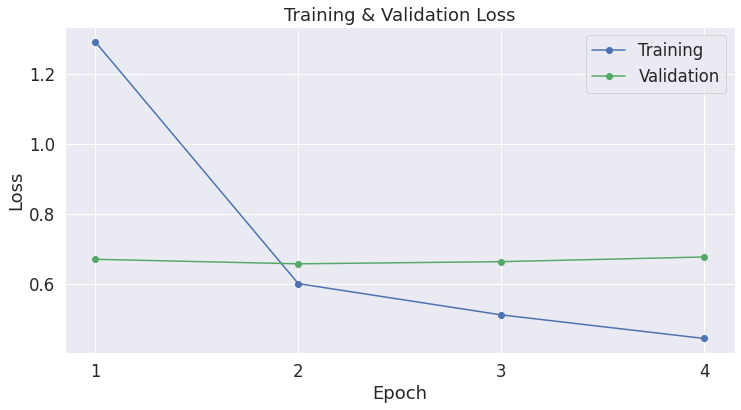

In [24]:
!matplotlib inline

pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [25]:
# Save the model
filename = f'08_output/models/{time.strftime("%y%m%d%H%M")}_{focus_cat}_language_model.pkl'
pickle.dump(model, open(filename, 'wb'))

# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))

### Generate Fake Text

In [26]:
# Printing long descriptions in Colab can be messy as they don't wrap
# Create simple function to split lines to set length
def split_input(user_string, chunk_size):
    output = []
    words = user_string.split(" ")
    total_length = 0

    while (total_length < len(user_string) and len(words) > 0):
        line = []
        next_word = words[0]
        line_len = len(next_word) + 1

        while  (line_len < chunk_size) and len(words) > 0:
            words.pop(0)
            line.append(next_word)

            if (len(words) > 0):
                next_word = words[0]
                line_len += len(next_word) + 1

        line = " ".join(line)
        output.append(line)
        total_length += len(line) 

    return output

In [28]:
train_or_load = input('Use trained model (t) or load existing (l): ')
if train_or_load == 'l':
    # load the model from disk
    lang_model_ref = lang_models[index]
    lang_model = pickle.load(open(f'08_output/models/{lang_model_ref}.pkl', 'rb'))
else:
    lang_model = model

Used trained model (t) or load existing (l):t


In [29]:
# Start by just generating a fake narrative using the trained model and no prompt text.
how_many_examples = 1
lang_model.eval()
prompt = "<|startoftext|>"
generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = lang_model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=how_many_examples,
                                pad_token_id = tokenizer.eos_token_id
                                )

for i, sample_output in enumerate(sample_outputs):
    fab_txt = split_input(tokenizer.decode(sample_output, skip_special_tokens=True), 80)
    for r, chunk in enumerate(fab_txt):
        if r == 0:
            head_txt = f'\nFake {i+1}:'
            print(head_txt)
            print('-'*(len(head_txt)-1))
            print(chunk)    
        else:
            print(chunk)


Fake 1:
-------
injured by slipping or swinging object held by injured worker an employee
pinch finger and thumb were amputating an 11th grade asphalt pipe employee was
using a torque wrench to loosen a small nut the employee finger broke striking
the end of the wrench causing an amputation employee was hospitalized


In [47]:
# Now lets use actual prompts designed for the focus group
# Load the prompts file created using separate scripts
prompts_file = pd.read_csv("04_rule_book/prompts.csv")

def clean_prompts(in_str):
    out_str = re.sub('\\[', '', in_str)
    out_str = re.sub('\\]', '', out_str)
    out_str = re.sub("'", '', out_str)
    out_str = out_str.split(", ")
    return(out_str)

In [48]:
prompts_file

,group,counts,prompts
0,competency,36,apprentice did not receive correct training_ c...
1,fall from or working at height issue,0,NaN
2,dropped object or material,78,bolt fell_ box fell_ crate fell_ debris fell_ ...
3,mechanical or equipment issue,105,bolt fault_ connector fault_ connection fault_...
4,fuel spill or leak,0,NaN
5,hydraulic fluid or oil leak,736,there was a leak_ there was a loss_ there was ...
6,hazardous materials or work,0,NaN
7,environmental leak or issue,0,NaN
8,line strike,1512,digger burst buried pipe_ digger burst buried ...
9,ppe non-compliance,206,apprentice not wearing correct gloves_ apprent...


In [49]:
prompts_for_group = prompts_file[prompts_file['group'] == focus_cat]
prompts_for_group

,group,counts,prompts
3,mechanical or equipment issue,105,bolt fault_ connector fault_ connection fault_...


In [50]:
# Create a list of prompts for the focus group only
num_unique_prompts = prompts_for_group['counts'].iloc[0]
print(f"There are {num_unique_prompts} unique prompts...")
prompts_list = prompts_for_group['prompts'].iloc[0].split('_ ')

There are 105 unique prompts...


In [51]:
# Quick visual inspection of prompts
prompts_list

['bolt fault',
 'connector fault',
 'connection fault',
 'compressor fault',
 'coupling fault',
 'drill fault',
 'generator fault',
 'hydraulic unit fault',
 'hydraulic hose fault',
 'hose fault',
 'pump fault',
 'plant fault',
 'turbine fault',
 'valve fault',
 'failure of bolt',
 'failure of connector',
 'failure of connection',
 'failure of compressor',
 'failure of coupling',
 'failure of drill',
 'failure of generator',
 'failure of hydraulic unit',
 'failure of hydraulic hose',
 'failure of hose',
 'failure of pump',
 'failure of plant',
 'failure of turbine',
 'failure of valve',
 'component failure in bolt',
 'component failure in connector',
 'component failure in connection',
 'component failure in compressor',
 'component failure in coupling',
 'component failure in drill',
 'component failure in generator',
 'component failure in hydraulic unit',
 'component failure in hydraulic hose',
 'component failure in hose',
 'component failure in pump',
 'component failure in plant'

In [52]:
# Now loop through and create n different narratives from each prompt
# using the language model decoder
all_fab_txts = []
ECHO=False

# Create n different narratives per prompt...
# Target n number of augments so that there is consistency betweem groups when evaluating impact
# of the augmentation
target_num_of_augs = 8000
HOW_MANY_PER_PROMPT = ceil(target_num_of_augs / num_unique_prompts)
print(f'Faking: {focus_cat}')
print(f'Generating {HOW_MANY_PER_PROMPT} x {num_unique_prompts} fake narratives...')

for p in tqdm(prompts_list):
    how_many_examples = HOW_MANY_PER_PROMPT
    lang_model.eval()
    prompt = "<|startoftext|>"+p
    generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
    generated = generated.to(device)

    sample_outputs = lang_model.generate(
                                    generated, 
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length=400,
                                    top_p=0.95, 
                                    num_return_sequences=how_many_examples,
                                    no_repeat_ngram_size=2,
                                    pad_token_id = tokenizer.eos_token_id
                                    )

    for i, sample_output in enumerate(sample_outputs):
        fab_txt = tokenizer.decode(sample_output, skip_special_tokens=True)
        all_fab_txts.append(fab_txt)
        if ECHO:
            fab_txt = split_input(fab_txt, 80)
            for r, chunk in enumerate(fab_txt):
                if r == 0:
                    head_txt = f'\nFake {i+1}:'
                    print(head_txt)
                    print('-'*(len(head_txt)-1))
                    print(chunk)    
                else:
                    print(chunk)

df_fab_txts = pd.DataFrame(all_fab_txts, columns = ['text'])
df_fab_txts['group'] = focus_cat

Faking: mechanical or equipment issue
Generating 77 x 105 fake narratives...


100%|██████████| 105/105 [39:33<00:00, 22.61s/it]


In [53]:
# Check the the number of fake narrratives (should be n x unique prompt count)
rep_count = len(df_fab_txts)
print('No. of fabricated reports: ', rep_count)

# Now write the fake data to the 'fabricated' subfolder of the data folder
# This data will be used for transformer-based data augmentation (TrDA)
df_fab_txts.to_csv(f'01_data/fabricated/{focus_cat}_{rep_count}_trda.csv', index=False)
df_fab_txts

No. of fabricated reports:  8085


,text,group
0,bolt fault ae9053ci at 1150hrs found bent bolt...,mechanical or equipment issue
1,bolt fault incident 31626on tdc motorized tcc ...,mechanical or equipment issue
2,bolt faulting incident 34253worker was cutting...,mechanical or equipment issue
3,bolt fault investigation commenced,mechanical or equipment issue
4,bolt fault incident 37828on friday two thousan...,mechanical or equipment issue
...,...,...
8080,faulty connection to fpso incident 31459at app...,mechanical or equipment issue
8081,faulty connection to electrical lighting circu...,mechanical or equipment issue
8082,faulty connection to power cable during instal...,mechanical or equipment issue
8083,faulty connection fpso incident 33852on july t...,mechanical or equipment issue


In [54]:
# Now visually inspect a random sample of 20
from IPython.display import display, HTML
table = df_fab_txts.sample(20)
display(HTML(table.to_html()))

,text,group
7497,"failed valve hydraulic hose was crushed resulting in a burst pump failure and hydraulic oil on hose side ruptured at approximately five hundred and fifty pm on ninety million, one hundred, three thousand and seventeen at around five thousand, thirty pm see attached report hydraulic fluids on tbt spill area hydraulic fluid mix tested negative batch status checked hydrostatic and amec foster wheel hydraulic system rupturing and rupturming at 5kp hydraulic crew notified at the end of shift hydraulic spill kit was taken out the spill kits were inspected and a pneumatic torque wrench was used to loosen hydraulic bolts hydraulic equipment on shift was repaired and checked to ensure all joints and cables were in place hydraulic leak testing of hydraulic systems was stopped and replaced spill cleaned up equipment used for testing was flushed and rerouted hydraulic work stopped to investigate the damage to the hydraulic integrity unit and to provide the technician with mechanical support to continue the tests hydraulic service was temporarily suspended",mechanical or equipment issue
1634,failure of hydraulic unit cable to install new power cable in arcing arc welding process failure of cable was caused by failure to use hydraulic hose for welding electrical cable arced arc resulting in failure arc welders electrical technician to begin work with bolt head on hand the arc was inspected upon completing the inspection work was concluded with a bolthead on the ground so that there would be no hazard of the weld area being affected by the arched arc the new hydraulic supply was provided and the area tested for ars and approved for future use no other hazards or defects were identified this work will be stopped immediately and will result in no issues with arsecured welding material and weld surfaces,mechanical or equipment issue
6666,failed connection to electrical line supplying power to dpe m e c an employee was attempting to remove a redundant power line from moe c during the removal of the redundant line a colleague and supervisor came forward and reported the incident with mewp senior hse supervisor who then reported to management for review,mechanical or equipment issue
2865,component failure in hose resulting from ground movement of scaffold components or materials was identified by the client during the initial testing phase of this project a component failure was observed within a few hs as the ground motion of the scaffolder components was more in number of moves the property damage is estimated to have been less than 10k but is significant enough to put an immediate stop to this type of damage and requires further investigation,mechanical or equipment issue
7873,leaking connection to electrical power cable during operation investigation commenced,mechanical or equipment issue
2903,component failure in hose to close during open circuit break from electrical service an employee received a mechanical failure and reported it to his supervisor who reported the incident to the foreman electrical technician who was then tasked to open the circuit breaker and open a secondary breaker when the electrical client had failed to disconnect power and the main breaker failed the client reported to supervisor the same incident occurred on numerous occassions e e nvironmental and hydrocarbons management actions initiated to reduce the risk of moisture in the surrounding waterways e c the task of disconnecting the primary breaker circuit was performed by a foreperson mechanical technician located at the substation where electrical services were being disconnected e o the area was barricaded off e l emergency generators were switched off and a cordoned off at a distance until the emergency generator unit can be established in time e a survey and investigation were carried out at an alternative location to be able to assess and determine whether electrical connections have been severed electrical contractor wood group was tasked wi

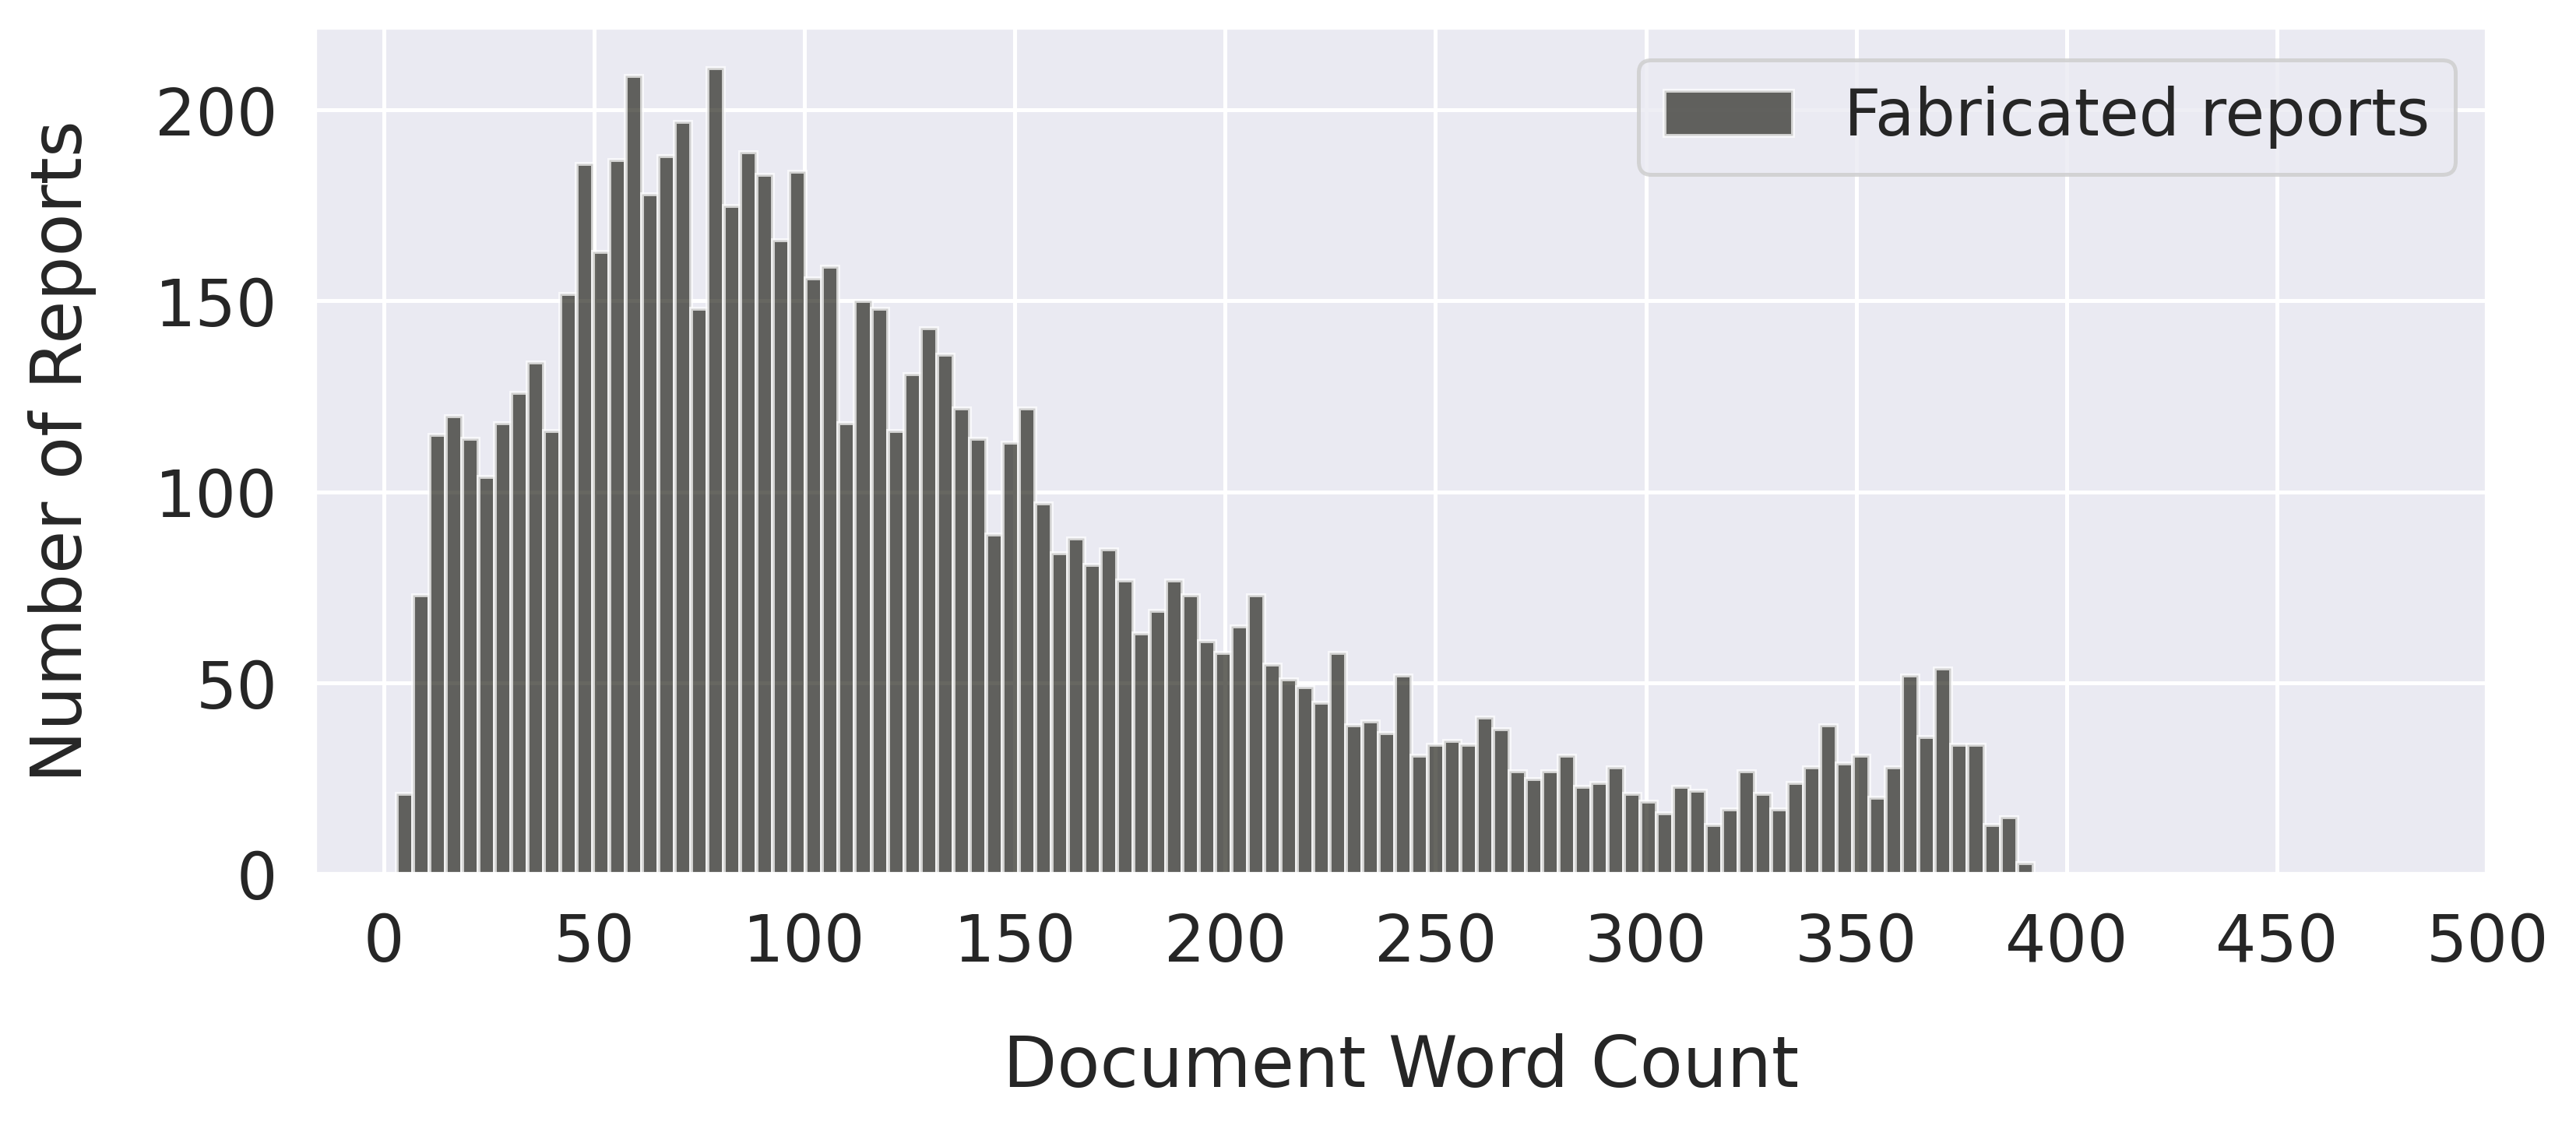

In [55]:
# Plot a histogram of word counts in the fake narratives
# Remember the real raw data has a mean word count of 62 and 95 percentile value of 309 words
# We expect to see similar distribution for the fake narratives...
doc_lens = [len(d.split()) for d in df_fab_txts.text]
plt.figure(figsize=(10, 4), dpi=360)
plt.hist(doc_lens, bins = 100, color='#26261e', alpha=0.7, label = 'Fabricated reports')
plt.legend(loc = 'upper right')

plt.xlabel("Document Word Count", labelpad = 15)
plt.ylabel("Number of Reports", labelpad = 15)
plt.tick_params(size=6)
plt.xticks(np.linspace(0, 500, 11))
plt.title('', fontdict=dict(size=10))
plt.show()